# BerlinMOD Queries

So far we have replicated the BerlinMOD Pymeos tutorial using Pyspark. Now we will execute a subset of the BerlinMOD queries.

In [1]:
cd "../sf0.1/"

/usr/local/lib/python3.9/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/data/sf0.1


In [2]:
ls -lh

total 2.7G
-rw-r--r--  1 root root  86K Jul 13 18:29 brussels_region.csv
-rw-rw-r--  1 root root 4.0K May 16 15:23 input_berlinmod.sql
-rw-rw-r--  1 root root 3.3K May 16 09:47 instants.csv
-rw-rw-r--  1 root root 1.6K May 16 09:47 licences.csv
-rw-rw-r--  1 root root 279K May 22 17:00 municipalities.csv
-rw-rw-r--  1 root root 1.5K May 16 15:22 output_berlinmod.sql
-rw-rw-r--  1 root root  13K Jul 13 16:06 periods.csv
-rw-rw-r--  1 root root 5.6K Jul 13 18:19 points.csv
-rw-rw-r--  1 root root 148K May 16 09:47 regions.csv
drwxr-xr-x 10 root root  320 Jul 14 07:13 spark-warehouse/
-rw-rw-r--  1 root root 2.6G May 16 09:41 tripsinput.csv
-rw-r--r--  1 root root  16M Jul 13 16:25 tripsinputsmall.csv
-rw-rw-r--  1 root root  20K May 16 09:47 vehicles.csv


In [3]:
rm -R spark-warehouse/

## Imports

In [4]:
from pymeos import *
from pymeos.plotters import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pysparkmeos.UDT.MeosDatatype import *

from pysparkmeos.partitions.grid.grid_partitioner import GridPartition
from pysparkmeos.partitions.kdtree_partitioner import KDTreePartition
from pysparkmeos.partitions.adaptive_partitioner_spark import AdaptiveBinsPartitionerSpark
from pysparkmeos.partitions.approx_adaptive_partitioner import ApproximateAdaptiveBinsPartitioner

from pysparkmeos.utils.udt_appender import *
from pysparkmeos.utils.utils import *

from pysparkmeos.UDF.udf import *
from pysparkmeos.UDTF.BerlinMOD import *

from pysparkmeos.BerlinMOD.config import load_config
from pysparkmeos.BerlinMOD.queries import *
from pysparkmeos.BerlinMOD.transformation_queries import *
from pysparkmeos.BerlinMOD.partition_queries import *
from pysparkmeos.BerlinMOD.func import *

import random, datetime, os, sys
from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import pandas as pd
import shapely.geometry as shp

import matplotlib.pyplot as plt
import numpy as np
from shapely import wkb, box, from_wkb
from typing import Union
from time import time

## Spark Initialization

In [5]:
def startspark():
    # Initialize PyMEOS
    pymeos_initialize("UTC")
    
    os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
    os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
    os.environ['PYSPARK_PYTHON'] = sys.executable
    
    # Initialize a Spark session
    spark = SparkSession.builder \
        .appName("BerlinMOD with PySpark") \
        .master("local[3]") \
        .config("spark.default.parallelism", 12) \
        .config("spark.executor.memory", "3g") \
        .config("spark.executor.cores", 1) \
        .config("spark.driver.memory", "2g") \
        .config("spark.driver.maxResultSize", 0) \
        .config("spark.sql.execution.arrow.maxRecordsPerBatch", "500") \
        .config("spark.sql.allowMultipleTableArguments.enabled", True) \
        .getOrCreate()
        
    # Append the UDT mapping to the PyMEOS classes
    udt_append()
    
    # Get the value of 'spark.default.parallelism'
    default_parallelism = spark.sparkContext.getConf().get("spark.default.parallelism")
    print(f"spark.default.parallelism: {default_parallelism}")

    # Register udfs in Spark SQL
    register_udfs_under_spark_sql(spark)

    # Register the udtfs in Spark SQL
    register_udtfs_under_spark_sql(spark)

    return spark

spark = startspark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/14 07:18:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


spark.default.parallelism: 12


24/07/14 07:18:18 WARN SimpleFunctionRegistry: The function length replaced a previously registered function.
24/07/14 07:18:18 WARN SimpleFunctionRegistry: The function nearest_approach_distance replaced a previously registered function.


## Load Tables
We will use the power of Spark SQL to read in the raw dataframes and then create the tables.

In [6]:
ls

brussels_region.csv  licences.csv          periods.csv  tripsinput.csv
input_berlinmod.sql  municipalities.csv    points.csv   tripsinputsmall.csv
instants.csv         output_berlinmod.sql  regions.csv  vehicles.csv


## Experiments

Here you can run an experiment, select the experiment to run in this notebook.  
Available experiments:
1. Run Queries AS-IS (default PySpark partitioning).
2. Run Queries with Trips partitioned by vehid, using Hash Partitioning.
3. Run Queries with Trips partitioned by trip, using RegularGrid.
4. Run Queries with Trips partitioned by trip, using KDTreePartitioning.
5. Run Queries with Trips partitioned by trip, using AdaptiveBinsPartitioning with Spark background.
6. Run Queries with Trips partitioned by trip, using ApproximateAdaptiveBinsPartitioning.

In [7]:
# Change to your desired experiment number.
run_exp_number = 3

# Select the queries to run 
#querynumbers = [1, 2, 3, 4, 5, 6, 11, 12, 13, 15, 18, 20]
querynumbers = [3]

### Set up the configurations for the experiment

In [8]:
paths = {
    'trips': 'tripsinputsmall.csv',
    'instants': 'instants.csv',
    'licences': 'licences.csv',
    'periods': 'periods.csv',
    'points': 'points.csv',
    'regions': 'regions.csv',
    'vehicles': 'vehicles.csv',
    'municipalities': 'municipalities.csv'
}

transformation_queries_simple = {
    'trips': transtripssimple2,
    'instants': transinstantssimple,
    'periods': transperiodsimple,
    'points': transpointssimple,
    'regions': transregionssimple,
    'municipalities': transmunsimple
}
        
transformation_queries = {
    'trips': transtrips2,
    'instants': transinstants,
    'periods': transperiod,
    'points': transpoints,
    'regions': transregions,
    'municipalities': transmun
}

partition_queries = {
    'trips': parttrips
}

partition_keys = {
    'trips': 'tileid'
}

num_buckets = 8
inferSchema = True
header = True

In [9]:
configs_exp1 = load_config(
    spark=spark, 
    paths=paths, 
    trans_queries=transformation_queries_simple, 
    part_queries=None, 
    partition_keys=None,
    partitioner_class=None,
    partitioner_args=None,
    num_buckets = None,
    inferSchema = inferSchema,
    header=header
)

In [10]:
configs_exp2 = load_config(
    spark=spark, 
    paths=paths, 
    trans_queries=transformation_queries_simple, 
    part_queries=None, 
    partition_keys={'trips': 'vehid'},
    partitioner_class=None,
    partitioner_args=None,
    num_buckets = num_buckets,
    inferSchema = inferSchema,
    header=header
)

In [11]:
configs_exp3 = load_config(
    spark=spark, 
    paths=paths, 
    trans_queries=transformation_queries, 
    part_queries=partition_queries, 
    partition_keys=partition_keys,
    partitioner_class=GridPartition,
    partitioner_args={'cells_per_side': 8},
    num_buckets = num_buckets,
    inferSchema = inferSchema,
    header=header
)

In [12]:
configs_exp4 = load_config(
    spark=spark, 
    paths=paths, 
    trans_queries=transformation_queries, 
    part_queries=partition_queries, 
    partition_keys=partition_keys,
    partitioner_class=KDTreePartition,
    partitioner_args={
        'moving_objects': None, 
        'dimensions': ['x', 'y', 't'], 
        'max_depth': 11},
    num_buckets = num_buckets,
    inferSchema = inferSchema,
    header=header
)

In [13]:
configs_exp5 = load_config(
    spark=spark, 
    paths=paths, 
    trans_queries=transformation_queries, 
    part_queries=partition_queries, 
    partition_keys=partition_keys,
    partitioner_class=AdaptiveBinsPartitionerSpark,
    partitioner_args={
        'spark': spark, 
        'dfname': 'tripsRaw', 
        'colname': 'trip',
        'num_tiles': 8, 
        'dimensions': ['x', 'y', 't'], 
        'utc': "UTC"},
    num_buckets = num_buckets,
    inferSchema = inferSchema,
    header=header
)

In [14]:
configs_exp6 = load_config(
    spark=spark, 
    paths=paths, 
    trans_queries=transformation_queries, 
    part_queries=partition_queries, 
    partition_keys=partition_keys,
    partitioner_class=ApproximateAdaptiveBinsPartitioner,
    partitioner_args={
        'spark': spark,
        'df': None, 
        'colname': 'trip',
        'num_tiles': 8, 
        'dimensions': ['x', 'y', 't'], 
        'utc': "UTC",
        'tablename': "tripsRaw"},
    num_buckets = num_buckets,
    inferSchema = inferSchema,
    header=header
)

In [15]:
experiment_configs = {
    i+1: config 
    for i, config in enumerate([configs_exp1, configs_exp2, configs_exp3, configs_exp4, configs_exp5, configs_exp6])
}
config = experiment_configs[run_exp_number]

queries = {
    1: querytext1,
    2: querytext2,
    3: querytext3,
    4: querytext4,
    5: querytext5,
    6: querytext6,
    11: querytext11,
    12: querytext12,
    13: querytext13,
    15: querytext15,
    18: querytext18,
    20: querytext20
}

descriptions = {
    1: querydesc1,
    2: querydesc2,
    3: querydesc3,
    4: querydesc4,
    5: querydesc5,
    6: querydesc6,
    11: querydesc11,
    12: querydesc12,
    13: querydesc13,
    15: querydesc15,
    18: querydesc18,
    20: querydesc20
}

queries_to_run = [queries[querynum] for querynum in querynumbers if querynum in queries]
descriptions_to_run = [descriptions[querynum] for querynum in querynumbers if querynum in descriptions]

### Run the experiment

#### Create Tables

In [16]:
tables, stats = load_all_tables(spark, config)

Reading raw csv  tripsinputsmall.csv


Creating temp view of raw table
+------+-----+----------+-----+--------------------+--------------------+
|tripid|vehid| startdate|seqno|               point|                   t|
+------+-----+----------+-----+--------------------+--------------------+
|     1|    1|2020-06-01|    1|0101000020110F000...|2020-06-01 06:01:...|
+------+-----+----------+-----+--------------------+--------------------+

Schema and statistics of raw table
root
 |-- tripid: integer (nullable = true)
 |-- vehid: integer (nullable = true)
 |-- startdate: date (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- point: string (nullable = true)
 |-- t: timestamp (nullable = true)



24/07/14 07:18:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+--------------------+
|summary|            tripid|             vehid|             seqno|               point|
+-------+------------------+------------------+------------------+--------------------+
|  count|            159418|            159418|            159418|              159418|
|   mean|114.69066228405826|4.5976740393180195| 1.995075838362042|                NULL|
| stddev|  85.6792387574541| 3.093698731004946|1.1111676314993488|                NULL|
|    min|                 1|                 1|                 1|0101000020110F000...|
|    max|               250|                 9|                 8|0101000020110F000...|
+-------+------------------+------------------+------------------+--------------------+

Creating final table trips based on tripsRawNoCache, partitioned by tileid.


Bounds:  STBOX XT(((469819.06271261786,6582912.267282209),(500521.90800771996,6606871.682578203)),[2020-06-01 06:01:41+00, 2020-06-11 19:41:43+00))
Time to create partitioning grid:  0.3016846179962158  seconds.
+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((469819...|
|     1|STBOX XT(((469819...|
|     2|STBOX XT(((469819...|
|     3|STBOX XT(((469819...|
|     4|STBOX XT(((469819...|
|     5|STBOX XT(((469819...|
|     6|STBOX XT(((469819...|
|     7|STBOX XT(((469819...|
|     8|STBOX XT(((469819...|
|     9|STBOX XT(((469819...|
|    10|STBOX XT(((469819...|
|    11|STBOX XT(((469819...|
|    12|STBOX XT(((469819...|
|    13|STBOX XT(((469819...|
|    14|STBOX XT(((469819...|
|    15|STBOX XT(((469819...|
|    16|STBOX XT(((469819...|
|    17|STBOX XT(((469819...|
|    18|STBOX XT(((469819...|
|    19|STBOX XT(((469819...|
+------+--------------------+
only showing top 20 rows

Creating partitioned table... 


Final table created in 24.78193688392639 seconds


Final table trips schema:
root
 |-- vehid: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- seqno: integer (nullable = true)
 |-- sourcenode: integer (nullable = true)
 |-- targetnode: string (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)
 |-- license: string (nullable = true)
 |-- movingobjectid: string (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- movingobject: pythonuserdefined (nullable = true)

Reading raw csv  instants.csv
Creating temp view of raw table
+---------+--------------------+
|instantid|             instant|
+---------+--------------------+
|        1|2020-06-01 19:44:...|
+---------+--------------------+

Schema and statistics of raw table
root
 |-- instantid: integer (nullable = true)
 |-- instant: timestamp (nullable = true)

+-------+------------------+
|summary|         instantid|
+-------+------------------+
|  count|               100|
|   mean|              50.5|
| stddev|29.011491975882016|
|    min|   

Final table created in 6.178069591522217 seconds
Final table instants schema:
root
 |-- instantid: integer (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- instant: pythonuserdefined (nullable = true)

Reading raw csv  licences.csv
Creating temp view of raw table
+---------+--------+-----+
|licenceid| licence|vehid|
+---------+--------+-----+
|        1|B-QS 276|  276|
+---------+--------+-----+

Schema and statistics of raw table
root
 |-- licenceid: integer (nullable = true)
 |-- licence: string (nullable = true)
 |-- vehid: integer (nullable = true)



+-------+------------------+--------+-----------------+
|summary|         licenceid| licence|            vehid|
+-------+------------------+--------+-----------------+
|  count|               100|     100|              100|
|   mean|              50.5|    NULL|           322.49|
| stddev|29.011491975882016|    NULL|173.2188721726581|
|    min|                 1|B-BJ 115|                9|
|    max|               100|B-[U 177|              622|
+-------+------------------+--------+-----------------+

Creating final table licences based on licencesRawNoCache, partitioned by None.


Final table created in 1.4646482467651367 seconds
Final table licences schema:
root
 |-- licenceid: integer (nullable = true)
 |-- licence: string (nullable = true)
 |-- vehid: integer (nullable = true)

Reading raw csv  periods.csv
Creating temp view of raw table
+--------+--------------------+--------------------+--------------------+
|periodid|              beginp|                endp|              period|
+--------+--------------------+--------------------+--------------------+
|       1|2020-06-09 11:15:...|2020-06-09 20:38:...|[2020-06-09 13:15...|
+--------+--------------------+--------------------+--------------------+

Schema and statistics of raw table
root
 |-- periodid: integer (nullable = true)
 |-- beginp: timestamp (nullable = true)
 |-- endp: timestamp (nullable = true)
 |-- period: string (nullable = true)

+-------+------------------+--------------------+
|summary|          periodid|              period|
+-------+------------------+--------------------+
|  count|     

Final table created in 6.464714050292969 seconds


Final table periods schema:
root
 |-- beginp: timestamp (nullable = true)
 |-- endp: timestamp (nullable = true)
 |-- periodid: integer (nullable = true)
 |-- tileid: integer (nullable = true)
 |-- period: pythonuserdefined (nullable = true)

Reading raw csv  points.csv
Creating temp view of raw table
+-------+----+----+--------------------+
|pointid|posx|posy|                geom|
+-------+----+----+--------------------+
|      1|NULL|NULL|0101000020110F000...|
+-------+----+----+--------------------+

Schema and statistics of raw table
root
 |-- pointid: integer (nullable = true)
 |-- posx: string (nullable = true)
 |-- posy: string (nullable = true)
 |-- geom: string (nullable = true)



+-------+------------------+----+----+--------------------+
|summary|           pointid|posx|posy|                geom|
+-------+------------------+----+----+--------------------+
|  count|               100|   0|   0|                 100|
|   mean|              50.5|NULL|NULL|                NULL|
| stddev|29.011491975882016|NULL|NULL|                NULL|
|    min|                 1|NULL|NULL|0101000020110F000...|
|    max|               100|NULL|NULL|0101000020110F000...|
+-------+------------------+----+----+--------------------+

Creating final table points based on pointsRawNoCache, partitioned by None.


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

#### Execute Queries

In [17]:
qdfs_exp, stats_exp = run_all_queries(
    queries_to_run, 
    descriptions_to_run, 
    spark, 
    explain=True, 
    printplan=False
)

Query 3: Where have the vehicles with licences from QueryLicences1 been at each of the instants from QueryInstants1?


+-----+-------+---------+---+
|vehid|licence|instantid|pos|
+-----+-------+---------+---+
+-----+-------+---------+---+

Query execution time:  2.5258517265319824  seconds.


## Mapping the regions and trips

In [18]:
ls

brussels_region.csv  municipalities.csv    regions.csv          vehicles.csv
input_berlinmod.sql  output_berlinmod.sql  spark-warehouse/
instants.csv         periods.csv           tripsinput.csv
licences.csv         points.csv            tripsinputsmall.csv


Text(0.5, 1.0, 'BerlinMOD Sample Trajectories Plot')

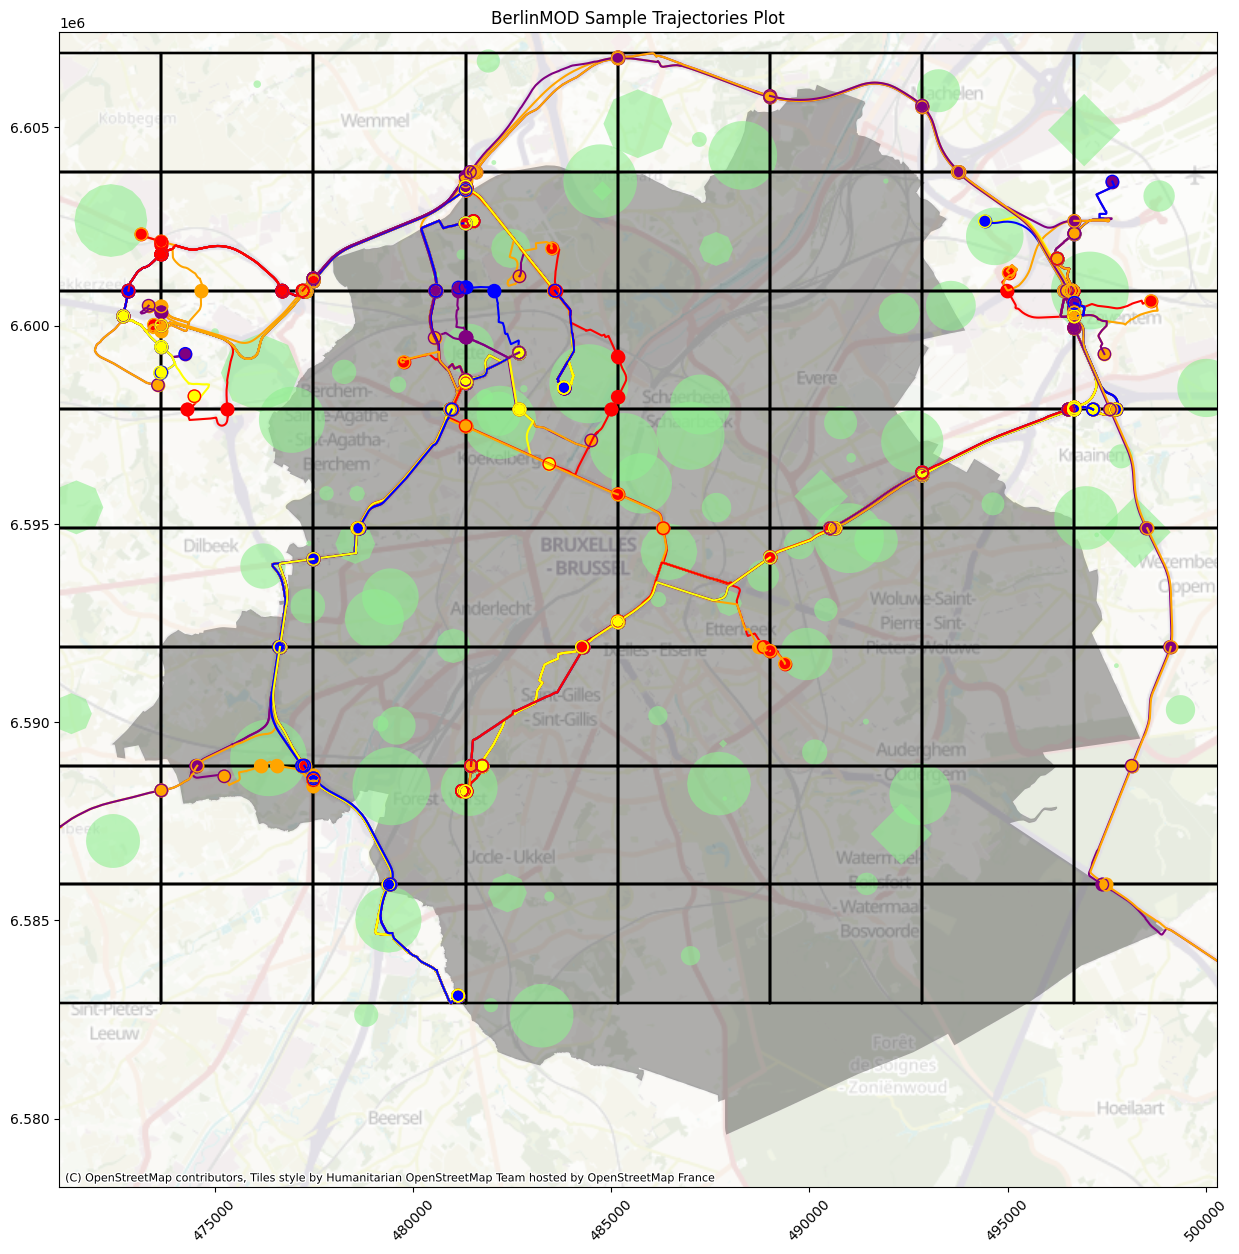

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
brussels = pd.read_csv(
    "brussels_region.csv", converters={"geom": partial(wkb.loads, hex=True)}
)
brussels = gpd.GeoDataFrame(brussels, geometry="geom")
brussels_geom = brussels["geom"][0]
brussels.plot(ax=ax, alpha=0.3, color='black')
cx.add_basemap(ax, alpha=0.3)
grid = spark.table('grid')

for gridrow in grid.toLocalIterator():
    gridrow.tile.plot_xy(axes=ax, color="black", draw_filling=False)

regions = spark.table('regions').select("regionid", "geom").distinct()

for regionrow in regions.toLocalIterator():
    myPoly = gpd.GeoSeries([regionrow.geom])
    myPoly.plot(ax=ax, alpha=0.6, color='lightgreen')
    
#trips = spark.table('trips').sample(0.1, seed=3).select('movingobjectid', 'movingobject')
trips = spark.table('trips').select('movingobjectid', 'movingobject')
colors = ['orange', 'red', 'yellow', 'blue', 'purple']
for triprow in trips.toLocalIterator():
    TemporalPointSequenceSetPlotter.plot_xy(
        triprow.movingobject, axes=ax, show_markers=True, show_grid=False, color=colors[int(triprow.movingobjectid) % len(colors)]
    )

#extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(f'BerlinMODSampleplot.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.title("BerlinMOD Sample Trajectories Plot")

In [20]:
jette_tiles = [
    row.tile 
    for row in spark.sql("""
        WITH tiles AS (
            SELECT DISTINCT tileid
            FROM municipalities
            WHERE name = 'Jette'
        )
        SELECT grid.* FROM grid INNER JOIN tiles ON (grid.tileid = tiles.tileid)
        """).collect()
]

auderghem_tiles = [
    row.tile 
    for row in spark.sql("""
        WITH tiles AS (
            SELECT DISTINCT tileid
            FROM municipalities
            WHERE name = 'Auderghem - Oudergem'
        )
        SELECT grid.* FROM grid INNER JOIN tiles ON (grid.tileid = tiles.tileid)
        """).collect()
]

Text(0.5, 1.0, 'BerlinMOD Sample Trajectories Plot')

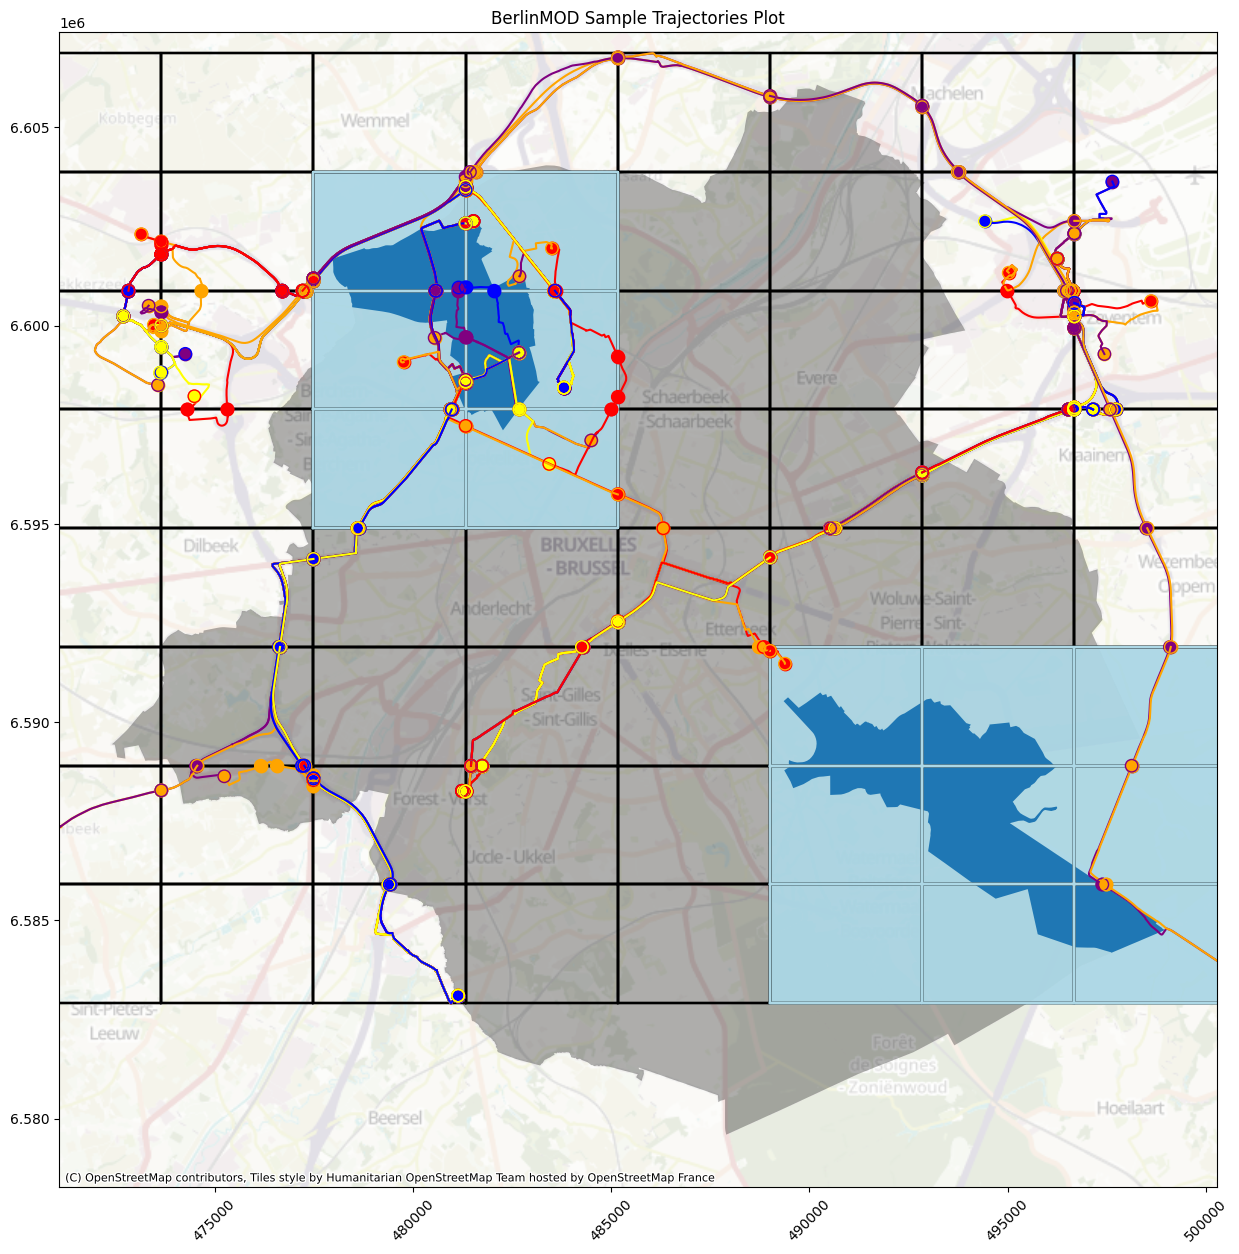

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
brussels = pd.read_csv(
    "brussels_region.csv", converters={"geom": partial(wkb.loads, hex=True)}
)
brussels = gpd.GeoDataFrame(brussels, geometry="geom")
brussels_geom = brussels["geom"][0]
brussels.plot(ax=ax, alpha=0.3, color='black')
cx.add_basemap(ax, alpha=0.3)
grid = spark.table('grid')

for gridrow in grid.toLocalIterator():
    gridrow.tile.plot_xy(axes=ax, color="black", draw_filling=False)

for tile in jette_tiles:
    tile.plot_xy(axes=ax, color="lightblue", draw_filling=True)

for tile in auderghem_tiles:
    tile.plot_xy(axes=ax, color="lightblue", draw_filling=True)

munis = gpd.GeoDataFrame(spark.sql("SELECT DISTINCT name, geom FROM municipalities WHERE name = 'Jette' OR name = 'Auderghem - Oudergem' LIMIT 2").toPandas(), geometry="geom")
munis.plot(ax=ax)

trips = spark.table('trips').select('movingobjectid', 'movingobject')
colors = ['orange', 'red', 'yellow', 'blue', 'purple']
for triprow in trips.toLocalIterator():
    TemporalPointSequenceSetPlotter.plot_xy(
        triprow.movingobject, axes=ax, show_markers=True, show_grid=False, color=colors[int(triprow.movingobjectid) % len(colors)]
    )

#extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(f'BerlinMODSampleplot.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.title("BerlinMOD Sample Trajectories Plot")

Text(0.5, 1.0, 'BerlinMOD Sample Trajectories Plot')

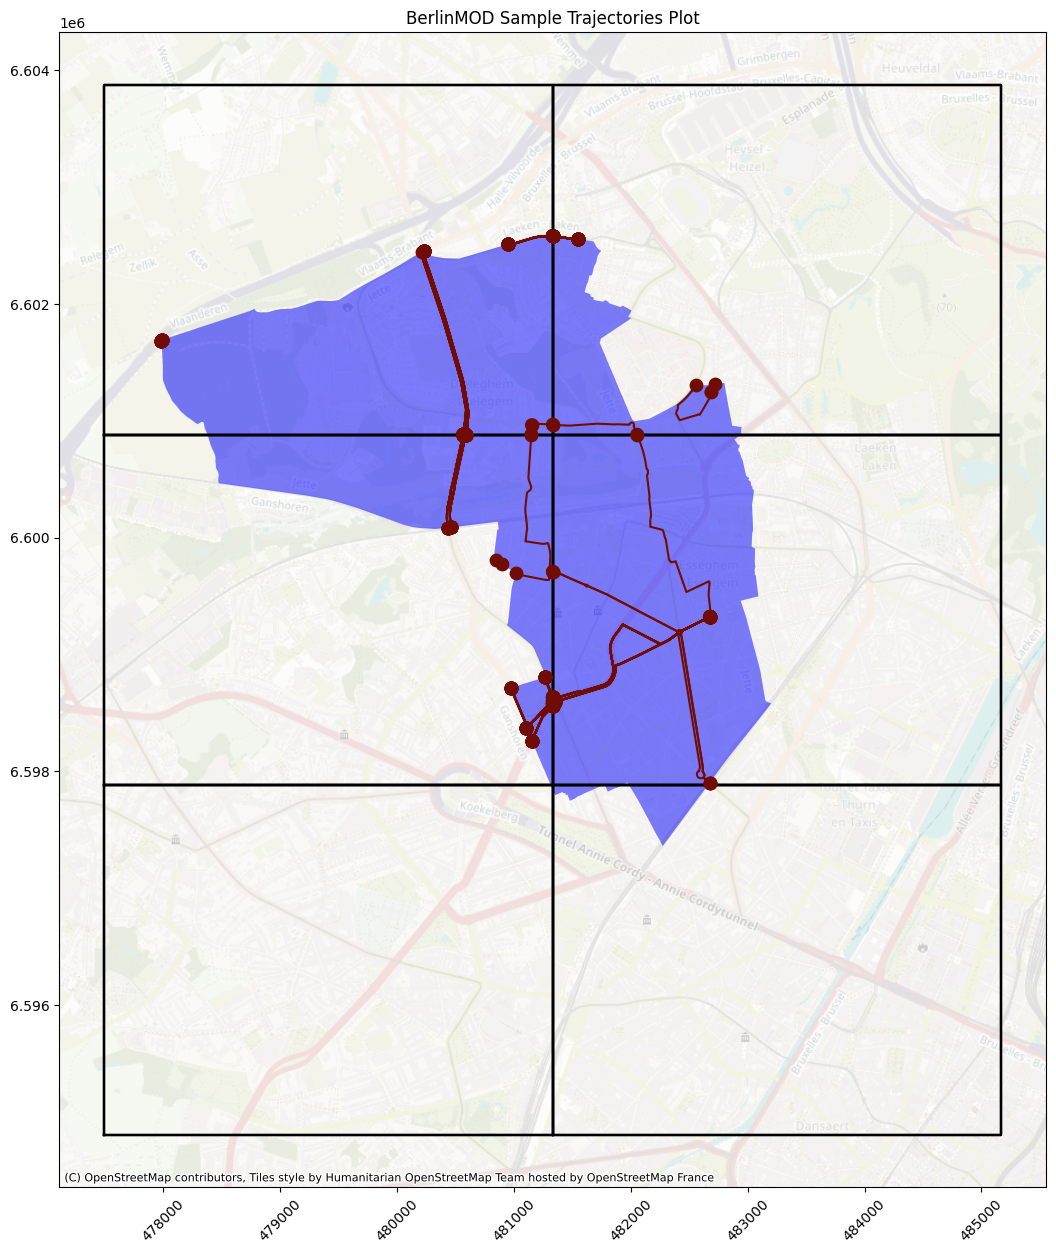

In [22]:
jette_trajs = spark.sql("""
    WITH jette AS (
        SELECT tileid, geom, municipalityid
        FROM municipalities
        WHERE name = 'Jette'
    )
    SELECT vehid, movingobjectid, movingobject, j.geom, t.tileid, j.municipalityid, at_geom(movingobject, geom) AS atgeom
    FROM trips t INNER JOIN jette j ON (t.tileid = j.tileid)
    WHERE ever_intersects(t.movingobject, j.geom) = TRUE
    ORDER BY vehid, movingobjectid, tileid
        """)

jette_tiles = [
    row.tile 
    for row in spark.sql("""
        WITH tiles AS (
            SELECT DISTINCT tileid
            FROM municipalities
            WHERE name = 'Jette'
        )
        SELECT grid.* FROM grid INNER JOIN tiles ON (grid.tileid = tiles.tileid)
        """).collect()
]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

grid = spark.table('grid')

for tile in jette_tiles:
    tile.plot_xy(axes=ax, color="black", draw_filling=False)

colors = ['orange', 'red', 'yellow', 'blue', 'purple']

for i, row in enumerate(jette_trajs.toLocalIterator()):
    if i == 0:
        geom = gpd.GeoDataFrame(jette_trajs.limit(1).toPandas(), geometry="geom")
        geom.plot(ax=ax, alpha=0.5, color='blue')
    TemporalPointSequenceSetPlotter.plot_xy(
        row.atgeom, axes=ax, show_markers=True, show_grid=False, color='#700c04'
    )
cx.add_basemap(ax, alpha=0.3)

#extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(f'BerlinMODSampleplot.svg', bbox_inches=extent)  # Adjust expanded() parameters as needed

plt.title("BerlinMOD Sample Trajectories Plot")

In [23]:
@F.udf(returnType=TGeomPointSeqUDT())
def tgeompointseq_from_tpoint_list(tpoints, utc="UTC"):
    pymeos_initialize(utc)
    tpoints = pd.DataFrame(tpoints, columns=['point', 'ts']).drop_duplicates(subset=['ts']).sort_values(by="ts")
    tpoints['tpoint'] = tpoints.apply(lambda x: TGeomPointInst(point=x['point'], timestamp=x['ts']), axis=1)
    try:
        tgeompointseq = TGeomPointSeq(instant_list=tpoints['tpoint'])
        return tgeompointseq
    except:
        return None
        
spark.udf.register("tgeompointseq_from_tpoint_list", tgeompointseq_from_tpoint_list)


transtrips2 = """
    WITH instants AS (
        SELECT 
            vehid,
            tripid,
            seqno,
            array(point, date_trunc("second", t)) AS tpoint,
            t
        FROM tripsRawNoCache
    )
    SELECT 
        tripid, 
        vehid,
        NULL AS day,
        seqno,
        NULL AS sourcenode,
        NULL AS targetnode,
        tgeompointseq_from_tpoint_list(collect_list(tpoint)) AS trip,
        NULL AS trajectory,
        NULL AS licence
    FROM instants
    GROUP BY vehid, tripid, seqno
"""
start = time()
df = spark.read.csv("tripsinputsmall.csv", header=True, inferSchema=True)
df.createOrReplaceTempView('tripsRawNoCache')
spark.sql(transtrips2).cache().show()
end = time()

print(end-start)

24/07/14 07:15:23 WARN SimpleFunctionRegistry: The function tgeompointseq_from_tpoint_list replaced a previously registered function.


+------+-----+----+-----+----------+----------+--------------------+----------+-------+
|tripid|vehid| day|seqno|sourcenode|targetnode|                trip|trajectory|licence|
+------+-----+----+-----+----------+----------+--------------------+----------+-------+
|    84|    3|NULL|    1|      NULL|      NULL|[POINT(481350.365...|      NULL|   NULL|
|    70|    3|NULL|    3|      NULL|      NULL|[POINT(481350.365...|      NULL|   NULL|
|   230|    9|NULL|    1|      NULL|      NULL|[POINT(472699.816...|      NULL|   NULL|
|   231|    9|NULL|    2|      NULL|      NULL|[POINT(483810.748...|      NULL|   NULL|
|     5|    1|NULL|    1|      NULL|      NULL|[POINT(496253.840...|      NULL|   NULL|
|    12|    1|NULL|    2|      NULL|      NULL|[POINT(481241.171...|      NULL|   NULL|
|   222|    9|NULL|    3|      NULL|      NULL|[POINT(472699.816...|      NULL|   NULL|
|    80|    3|NULL|    3|      NULL|      NULL|[POINT(481350.365...|      NULL|   NULL|
|   242|    9|NULL|    6|      N

In [24]:
spark.sql("SHOW TABLES").show()

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|  default|     instantsnocache|      false|
|  default|     licencesnocache|      false|
|  default|municipalitiesnoc...|      false|
|  default|      periodsnocache|      false|
|  default|       pointsnocache|      false|
|  default|      regionsnocache|      false|
|  default|        tripsnocache|      false|
|  default|     vehiclesnocache|      false|
|         |                grid|       true|
|         |            instants|       true|
|         |         instantsraw|       true|
|         |  instantsrawnocache|       true|
|         |            licences|       true|
|         |         licencesraw|       true|
|         |  licencesrawnocache|       true|
|         |      municipalities|       true|
|         |   municipalitiesraw|       true|
|         |municipalitiesraw...|       true|
|         |             periods|       true|
|         

In [25]:
spark.sql("SELECT * FROM tripsnocache").show()

+-----+----+-----+----------+----------+----------+-------+--------------+------+--------------------+
|vehid| day|seqno|sourcenode|targetnode|trajectory|license|movingobjectid|tileid|        movingobject|
+-----+----+-----+----------+----------+----------+-------+--------------+------+--------------------+
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|             1|   280|{[POINT(489008.34...|
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|             9|   202|{[POINT(481467.75...|
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|             9|   218|{[POINT(485170.48...|
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|             9|   282|{[POINT(489008.34...|
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|             9|   418|{[POINT(496531.53...|
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|             9|   434|{[POINT(496253.84...|
|    1|NULL|    1|      NULL|      NULL|      NULL|   NULL|            11